# TFM - Predicción potenciales compradores de un ecommerce

Evolución del notebook *Modelo_1.ipynb* unicamente aplicando a **Altas**

------------------------------------

------------------

### 1.1 Librerias

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import ParameterGrid

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier, RUSBoostClassifier, EasyEnsembleClassifier

from collections import Counter

pd.set_option('display.max_columns', 200)

import warnings
warnings.filterwarnings("ignore")

------------------

### 1.2 Variables globales

In [2]:
LABELS = ["No_Alta","Alta"]

------------------

### 1.3 Funciones

In [3]:
def mostrar_resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize = (8, 8))
    sns.heatmap(conf_matrix, xticklabels = LABELS, yticklabels = LABELS, annot = True, fmt = "d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print (classification_report(y_test, pred_y))

------------------------------------

------------------

A continuación comenzamos leyendo los ficheros que hemos tratado, limpiado y analizado en los procesos anteriores.

Se realizará un análisis sencillo de la estructura y una visualización de varias muestras. 

Además someteremos las variables categóricas a variables *dummies*, de forma que que podamos introducirlas ennuestro modelo.

### 2.1 Lectura de Fichero

In [4]:
df = pd.read_csv('Data/dataset_model.txt', sep = ';', encoding = 'ISO-8859-1')

In [5]:
df.shape

(367632, 55)

In [6]:
df.head(3)

,TIPOUSUARIO,FECHA_REGISTRO_BUSINESS_DAY,FECHA_REGISTRO_WEEKDAY,FECHA_REGISTRO_MONTH,CANAL_REGISTRO,FECHA_ALTA_BUSINESS_DAY,FECHA_ALTA_WEEKDAY,FECHA_ALTA_MONTH,REGISTRO_ALTA,IND_ALTA,FECHA_CLIENTE_BUSINESS_DAY,FECHA_CLIENTE_WEEKDAY,FECHA_CLIENTE_MONTH,IND_CLIENTE,TIPOEMAIL,EMAIL_PERSONAL,BONDAD_EMAIL,TIPO_TELF,IPCASOS,IP_CONTINENTE,IP_COLOMBIA,IP_COUNTRY_PIB,IP_COUNTRY_IDH_NUM,IP_COUNTRY_IDH_GROUP,USU_TIPO,USU_TAMANIO,USU_ESTADO,USU_SECTOR_ECONOMICO,USU_DEPART_DEN_POB,USU_DEPART_IDH,FECHACONSUMO_BUSINESS_DAY,FECHACONSUMO_WEEKDAY,FECHACONSUMO_MONTH,ALTA_CONSUMO,CLIENTE_CONSUMO,1A_DESCGRUPOPROD,1A_EMPCONSUL_EST,1A_EMPCONSUL_SECTOR,1A_EMPCONSUL_PROV_DENS,1A_EMPCONSUL_PROV_IDH,CONSUM_TOT,FICH_PROMO_TOT,PERF_PROMO_TOT,RES_PAGO_TOT,EST_ACTIVA_TOT,EST_INACTIVA_TOT,EST_REESTRUCT_TOT,EST_CLINTON_TOT,EST_NI_TOT,SECT_PRIM_TOT,SECT_SECU_TOT,SECT_TERC_TOT,SECT_CUAT_TOT,SECT_QUIN_TOT,SECT_SD_TOT
0,PF,1,1,10,3,-1,-1,-1,-1,0,-1,-1,-1,0,GOOHOTYAHMAIL,1,0,NO_PUBLICO,1,AMERICA_SUR,1,Ingreso mediano alto,0.767,Alto,NoApl,NoApl,NoApl,NoApl,-1.00,-1.000,1,1,10,-1,-1,PERF_PROMO,ACTIVA,TERCIARIO,47.92,0.782,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0
1,PJ,1,1,5,3,-1,-1,-1,-1,0,-1,-1,-1,0,GOOHOTYAHMAIL,1,1,NO_PUBLICO,1,AMERICA_SUR,1,Ingreso mediano alto,0.767,Alto,SOC_COMERCIAL_INDUSTRIAL,PQ,ACTIVA,TERCIARIO,306.38,0.832,1,1,5,-1,-1,PERF_PROMO,ACTIVA,SD,47.92,0.782,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1
2,PJ,1,2,9,7,-1,-1,-1,-1,0,-1,-1,-1,0,GOOHOTYAHMAIL,1,1,NO_PUBLICO,1,AMERICA_SUR,1,Ingreso mediano alto,0.767,Alto,SOC_COMERCIAL_INDUSTRIAL,MC,ACTIVA,TERCIARIO,815.17,0.835,1,2,9,-1,-1,PERF_PROMO,ACTIVA,TERCIARIO,4438.75,0.904,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0


------------------

### 2.2 Variables dummies

In [7]:
ohe_columns = ['TIPOUSUARIO','TIPOEMAIL','TIPO_TELF','IP_CONTINENTE','IP_COUNTRY_PIB','IP_COUNTRY_IDH_GROUP','USU_TIPO','USU_TAMANIO','USU_ESTADO','USU_SECTOR_ECONOMICO',
               '1A_DESCGRUPOPROD','1A_EMPCONSUL_EST','1A_EMPCONSUL_SECTOR']

In [8]:
final_df = pd.get_dummies(df, columns = ohe_columns)

**Columnas para la predicción**

In [9]:
columnas = ['TIPOUSUARIO_PF','TIPOUSUARIO_PJ','FECHA_REGISTRO_BUSINESS_DAY','FECHA_REGISTRO_WEEKDAY','FECHA_REGISTRO_MONTH','CANAL_REGISTRO','TIPOEMAIL_ADMINISTRACION','TIPOEMAIL_CORPORATIVO','TIPOEMAIL_DOCENTE',
            'TIPOEMAIL_GOOHOTYAHMAIL','TIPOEMAIL_SINCLASIFICAR','TIPOEMAIL_TEMPORAL','EMAIL_PERSONAL','BONDAD_EMAIL','TIPO_TELF_EXTRANJERO','TIPO_TELF_MOVIL','TIPO_TELF_NO_PUBLICO','IPCASOS','IP_CONTINENTE_AFRICA',
            'IP_CONTINENTE_AMERICA_NORTE','IP_CONTINENTE_AMERICA_SUR','IP_CONTINENTE_ASIA','IP_CONTINENTE_EUROPA','IP_CONTINENTE_NI','IP_CONTINENTE_OCEANNIA','IP_COLOMBIA','IP_COUNTRY_PIB_Ingreso alto',
            'IP_COUNTRY_PIB_Ingreso mediano alto','IP_COUNTRY_PIB_NI','IP_COUNTRY_PIB_Países de ingreso mediano bajo','IP_COUNTRY_IDH_NUM','USU_TIPO_EMPRESARIO INDIVIDUAL','USU_TIPO_ENTIDAD_HOLDING',
            'USU_TIPO_NI','USU_TIPO_NoApl','USU_TIPO_SOC_COMERCIAL_INDUSTRIAL','USU_TIPO_SOC_NO_COMERCIAL','USU_TAMANIO_GR','USU_TAMANIO_MC','USU_TAMANIO_MD','USU_TAMANIO_NoApl','USU_TAMANIO_PQ','USU_TAMANIO_SD',
            'USU_ESTADO_ACTIVA','USU_ESTADO_INACTIVA','USU_ESTADO_NoApl','USU_ESTADO_REESTRUCTURACION','USU_ESTADO_RELACION_CLINTON','USU_ESTADO_SD','USU_SECTOR_ECONOMICO_CUATERNARIO','USU_SECTOR_ECONOMICO_NoApl',
            'USU_SECTOR_ECONOMICO_PRIMARIO','USU_SECTOR_ECONOMICO_QUINARIO','USU_SECTOR_ECONOMICO_SD','USU_SECTOR_ECONOMICO_SECUNDARIO','USU_SECTOR_ECONOMICO_TERCIARIO','USU_DEPART_DEN_POB','USU_DEPART_IDH',
            'FECHACONSUMO_BUSINESS_DAY','FECHACONSUMO_WEEKDAY','FECHACONSUMO_MONTH','1A_DESCGRUPOPROD_FICH_PROMO','1A_DESCGRUPOPROD_PERF_PROMO','1A_DESCGRUPOPROD_RES_PAGO','1A_EMPCONSUL_EST_ACTIVA',
            '1A_EMPCONSUL_EST_INACTIVA','1A_EMPCONSUL_EST_NI','1A_EMPCONSUL_EST_REESTRUCTURACION','1A_EMPCONSUL_EST_RELACION_CLINTON','1A_EMPCONSUL_SECTOR_CUATERNARIO','1A_EMPCONSUL_SECTOR_PRIMARIO',
            '1A_EMPCONSUL_SECTOR_QUINARIO','1A_EMPCONSUL_SECTOR_SD','1A_EMPCONSUL_SECTOR_SECUNDARIO','1A_EMPCONSUL_SECTOR_TERCIARIO','1A_EMPCONSUL_PROV_DENS','1A_EMPCONSUL_PROV_IDH']

-----------------

------------------

### 3.1 Analisis desbalanceo

In [10]:
final_df.shape

(367632, 108)

In [11]:
pd.value_counts(final_df['IND_ALTA'], sort = True)

0    363923
1      3709
Name: IND_ALTA, dtype: int64

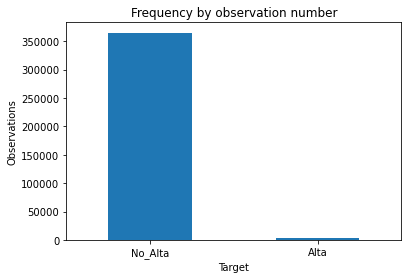

In [12]:
count_classes = pd.value_counts(final_df['IND_CLIENTE'], sort = True)
count_classes.plot(kind = 'bar', rot = 0)
plt.xticks(range(2), LABELS)
plt.title("Frequency by observation number")
plt.xlabel("Target")
plt.ylabel("Observations");

In [13]:
print('Los clientes suponen un % del total: ', (3709/final_df.shape[0])*100)

Los clientes suponen un % del total:  1.0088893241067154


------------------

------------------

### 4. Creación del Modelo

#### 4.1 Dividimos el set entre features y label

In [14]:
features = final_df[columnas]
labels = final_df['IND_ALTA']

In [15]:
features.shape

(367632, 77)

In [16]:
labels.shape

(367632,)

------------------

#### 4.2 Creamos set de entrenamiento y test

In [17]:
train_x, test_x, train_y, test_y = train_test_split(features, labels, test_size = 0.3, random_state = 123)

In [18]:
train_x.shape

(257342, 77)

In [19]:
test_x.shape

(110290, 77)

In [20]:
train_y.shape

(257342,)

In [21]:
test_y.shape

(110290,)

------------------

#### 4.3 Selección Hiperparámetros

Definimos una serie de hiperparámetros diferentes para comparar resultados

In [22]:
param_grid = ParameterGrid({'n_estimators': [5, 20, 50, 100, 150],
                            'max_features': [5, 'log2', 'auto', 'sqrt'],
                            'max_depth'   : [None, 3, 5, 7, 10],
                            'criterion'   : ['gini', 'entropy'],
                            'class_weight': ['balanced']
                           })

Loop para ajustar un modelo con cada combinación de hiperparámetros

In [23]:
resultados = {'params': [], 'oob_accuracy': []}

In [24]:
for params in param_grid:
    
    modelo = RandomForestClassifier(
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123,
                ** params
             )
    
    modelo.fit(train_x, train_y)
    
    resultados['params'].append(params)
    resultados['oob_accuracy'].append(modelo.oob_score_)
    print(f"Modelo: {params} \u2713")

Modelo: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 5} ✓
Modelo: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 20} ✓
Modelo: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 50} ✓
Modelo: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 100} ✓
Modelo: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 5} ✓
Modelo: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 20} ✓
Modelo: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 50} ✓
Modelo: {'class_weight': 'balanced', 'cri

In [25]:
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.drop(columns = 'params')
resultados = resultados.sort_values('oob_accuracy', ascending=False)
resultados.head(10)

,oob_accuracy,class_weight,criterion,max_depth,max_features,n_estimators
101,0.986419,balanced,entropy,NaN,5,20
106,0.986380,balanced,entropy,NaN,log2,20
11,0.986372,balanced,gini,NaN,auto,20
16,0.986372,balanced,gini,NaN,sqrt,20
1,0.986283,balanced,gini,NaN,5,20
6,0.986252,balanced,gini,NaN,log2,20
116,0.986228,balanced,entropy,NaN,sqrt,20
111,0.986228,balanced,entropy,NaN,auto,20
112,0.986073,balanced,entropy,NaN,auto,50
117,0.986073,balanced,entropy,NaN,sqrt,50


**Seleccionamos los mejores hiperparámetros**

In [26]:
print("Mejores hiperparámetros encontrados (oob-accuracy)")
print('--------------------------------------------------')
print("Estimators: \n", resultados.iloc[0,:], "accuracy")

Mejores hiperparámetros encontrados (oob-accuracy)
--------------------------------------------------
Estimators: 
 oob_accuracy    0.986419
class_weight    balanced
criterion        entropy
max_depth            NaN
max_features           5
n_estimators          20
Name: 101, dtype: object accuracy


--------------

--------------

#### 4.4 Modelo 1 - Baseline

Nuestro modelo Base, tendrá los parámetros obtenidos como mejores anteriormente.

**Aplicamos los mejores hiperparámetros obtenidos**

In [27]:
rf = RandomForestClassifier(criterion = 'entropy', 
                            n_estimators = 20, 
                            max_features = 5, 
                            max_depth = None, 
                            n_jobs = -1,
                            random_state = 123)

rf.fit(train_x, train_y)

RandomForestClassifier(criterion='entropy', max_features=5, n_estimators=20,
                       n_jobs=-1, random_state=123)

Observamos los resultados del modelo

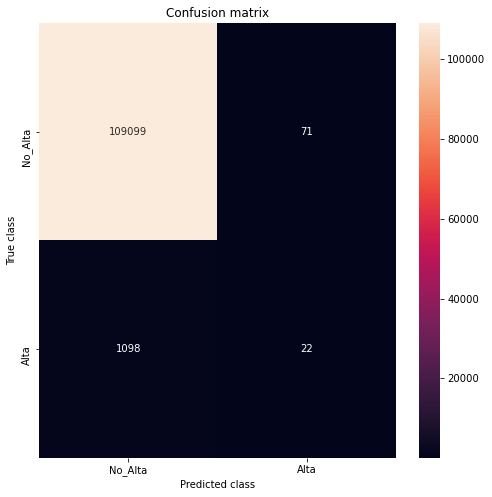

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    109170
           1       0.24      0.02      0.04      1120

    accuracy                           0.99    110290
   macro avg       0.61      0.51      0.52    110290
weighted avg       0.98      0.99      0.98    110290



In [28]:
pred_y = rf.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [29]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [30]:
feature_importances[feature_importances['important'] > 0.01]*100

,important
IPCASOS,11.670997
CANAL_REGISTRO,11.063410
FECHA_REGISTRO_MONTH,8.748905
FECHACONSUMO_MONTH,8.690356
FECHACONSUMO_WEEKDAY,6.093575
FECHA_REGISTRO_WEEKDAY,5.739293
1A_EMPCONSUL_PROV_DENS,5.736145
1A_EMPCONSUL_PROV_IDH,5.559727
USU_DEPART_DEN_POB,2.032261
BONDAD_EMAIL,1.904224


In [31]:
feature_importances[feature_importances['important'] > 0.01].shape

(18, 1)

------

------

------

#### 4.5 Modelo - Aplicando técnicas sobre el desbalanceo

**Estrategias para el manejo de Datos Desbalanceados**

##### **4.5.1 Penalización para compensar**

In [32]:
rf = RandomForestClassifier(criterion = 'entropy', 
                            n_estimators = 20, 
                            max_features = 5, 
                            max_depth = None, 
                            n_jobs = -1,
                            random_state = 123,
                            class_weight = 'balanced')

rf.fit(train_x, train_y)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_features=5, n_estimators=20, n_jobs=-1,
                       random_state=123)

Observamos los resultados del modelo

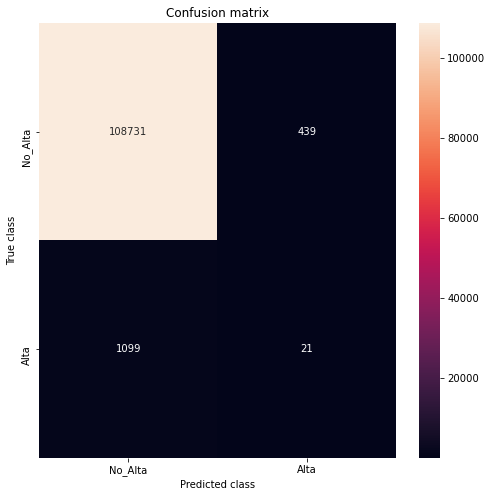

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    109170
           1       0.05      0.02      0.03      1120

    accuracy                           0.99    110290
   macro avg       0.52      0.51      0.51    110290
weighted avg       0.98      0.99      0.98    110290



In [33]:
pred_y = rf.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [34]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [35]:
feature_importances[feature_importances['important'] > 0.01]*100

,important
IPCASOS,10.197268
CANAL_REGISTRO,10.164672
FECHACONSUMO_MONTH,8.334739
FECHA_REGISTRO_MONTH,8.022671
1A_EMPCONSUL_PROV_DENS,6.084358
1A_EMPCONSUL_PROV_IDH,5.961763
FECHACONSUMO_WEEKDAY,5.751924
FECHA_REGISTRO_WEEKDAY,5.473394
BONDAD_EMAIL,3.392513
USU_DEPART_DEN_POB,1.937344


In [36]:
feature_importances[feature_importances['important'] > 0.01].shape

(21, 1)

------

##### **4.5.2 Subsampling en la clase mayoritaria**

**RandomUnderSampler**

In [37]:
us = RandomUnderSampler(sampling_strategy = 'majority', random_state = 123)
X_train_res, y_train_res = us.fit_resample(train_x, train_y)
 
print ("Distribution before resampling {}".format(Counter(train_y)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

Distribution before resampling Counter({0: 254753, 1: 2589})
Distribution after resampling Counter({0: 2589, 1: 2589})


In [38]:
rf = RandomForestClassifier(criterion = 'entropy', 
                            n_estimators = 20, 
                            max_features = 5, 
                            max_depth = None, 
                            n_jobs = -1,
                            random_state = 123)

rf.fit(X_train_res, y_train_res)

RandomForestClassifier(criterion='entropy', max_features=5, n_estimators=20,
                       n_jobs=-1, random_state=123)

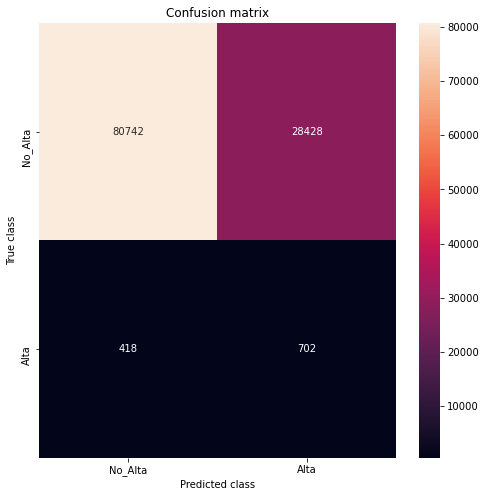

              precision    recall  f1-score   support

           0       0.99      0.74      0.85    109170
           1       0.02      0.63      0.05      1120

    accuracy                           0.74    110290
   macro avg       0.51      0.68      0.45    110290
weighted avg       0.98      0.74      0.84    110290



In [39]:
pred_y = rf.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [40]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [41]:
feature_importances[feature_importances['important'] > 0.01]*100

,important
IPCASOS,9.149647
CANAL_REGISTRO,9.101962
FECHA_REGISTRO_MONTH,8.441314
FECHACONSUMO_MONTH,8.358263
1A_EMPCONSUL_PROV_IDH,6.172643
1A_EMPCONSUL_PROV_DENS,5.829053
FECHACONSUMO_WEEKDAY,5.628298
FECHA_REGISTRO_WEEKDAY,5.421516
BONDAD_EMAIL,2.545543
TIPO_TELF_EXTRANJERO,1.905602


In [42]:
feature_importances[feature_importances['important'] > 0.01].shape

(23, 1)

------

**NearMiss**

In [43]:
us = NearMiss(sampling_strategy = 'majority', n_neighbors = 2, n_jobs = -1)
X_train_res, y_train_res = us.fit_resample(train_x, train_y)
 
print ("Distribution before resampling {}".format(Counter(train_y)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

Distribution before resampling Counter({0: 254753, 1: 2589})
Distribution after resampling Counter({0: 2589, 1: 2589})


In [44]:
rf = RandomForestClassifier(criterion = 'entropy', 
                            n_estimators = 20, 
                            max_features = 5, 
                            max_depth = None, 
                            n_jobs = -1,
                            random_state = 123)

rf.fit(X_train_res, y_train_res)

RandomForestClassifier(criterion='entropy', max_features=5, n_estimators=20,
                       n_jobs=-1, random_state=123)

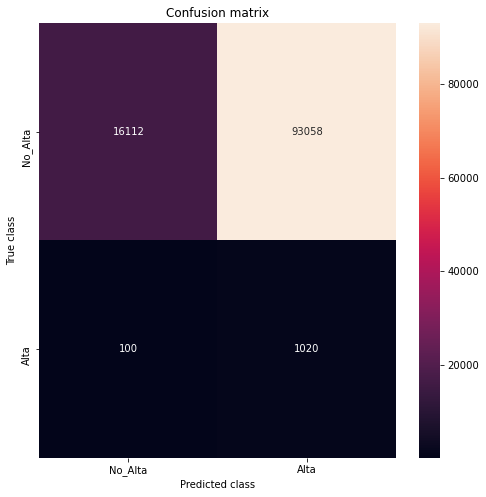

              precision    recall  f1-score   support

           0       0.99      0.15      0.26    109170
           1       0.01      0.91      0.02      1120

    accuracy                           0.16    110290
   macro avg       0.50      0.53      0.14    110290
weighted avg       0.98      0.16      0.25    110290



In [45]:
pred_y = rf.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [46]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [47]:
feature_importances[feature_importances['important'] > 0.01]*100

,important
IPCASOS,11.676536
TIPOEMAIL_GOOHOTYAHMAIL,7.534673
CANAL_REGISTRO,7.217261
1A_EMPCONSUL_PROV_IDH,5.670664
1A_EMPCONSUL_PROV_DENS,5.320215
USU_ESTADO_ACTIVA,4.048224
FECHACONSUMO_MONTH,4.015712
FECHA_REGISTRO_MONTH,3.936740
USU_SECTOR_ECONOMICO_NoApl,3.446774
1A_EMPCONSUL_SECTOR_TERCIARIO,2.848906


In [48]:
feature_importances[feature_importances['important'] > 0.01].shape

(26, 1)

------

------

##### **4.5.3 Oversampling en la clase minoritaria**

**SMOTE**

In [49]:
os =  SMOTE(sampling_strategy = 'minority')
X_train_res, y_train_res = os.fit_resample(train_x, train_y)

In [50]:
print ("Distribution before resampling {}".format(Counter(train_y)))
print ("Distribution labels after resampling {}".format(Counter(y_train_res)))

Distribution before resampling Counter({0: 254753, 1: 2589})
Distribution labels after resampling Counter({0: 254753, 1: 254753})


In [51]:
rf = RandomForestClassifier(criterion = 'entropy', 
                            n_estimators = 20, 
                            max_features = 5, 
                            max_depth = None, 
                            n_jobs = -1,
                            random_state = 123)

rf.fit(X_train_res, y_train_res)

RandomForestClassifier(criterion='entropy', max_features=5, n_estimators=20,
                       n_jobs=-1, random_state=123)

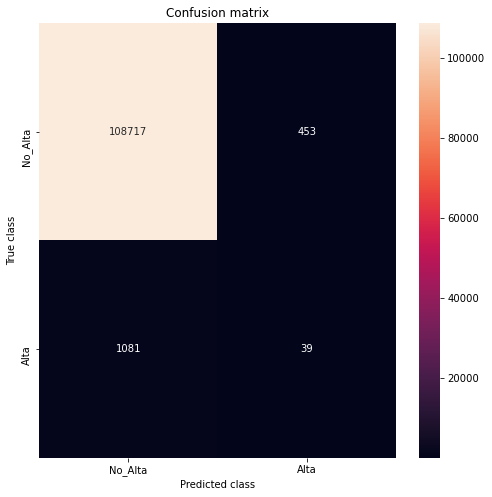

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    109170
           1       0.08      0.03      0.05      1120

    accuracy                           0.99    110290
   macro avg       0.53      0.52      0.52    110290
weighted avg       0.98      0.99      0.98    110290



In [52]:
pred_y = rf.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [53]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [54]:
feature_importances[feature_importances['important'] > 0.01]*100

,important
CANAL_REGISTRO,6.275258
TIPO_TELF_MOVIL,5.360137
IPCASOS,5.215650
TIPO_TELF_NO_PUBLICO,4.329535
TIPO_TELF_EXTRANJERO,4.304940
1A_EMPCONSUL_SECTOR_TERCIARIO,4.233661
1A_EMPCONSUL_SECTOR_SECUNDARIO,3.667856
FECHACONSUMO_MONTH,3.437154
1A_DESCGRUPOPROD_PERF_PROMO,3.366963
FECHA_REGISTRO_MONTH,3.268769


In [55]:
feature_importances[feature_importances['important'] > 0.01].shape

(33, 1)

------

**RandomOverSampler**

In [56]:
os =  RandomOverSampler(sampling_strategy = 'minority')
X_train_res, y_train_res = os.fit_resample(train_x, train_y)

In [57]:
print ("Distribution before resampling {}".format(Counter(train_y)))
print ("Distribution labels after resampling {}".format(Counter(y_train_res)))

Distribution before resampling Counter({0: 254753, 1: 2589})
Distribution labels after resampling Counter({0: 254753, 1: 254753})


In [58]:
rf = RandomForestClassifier(criterion = 'entropy', 
                            n_estimators = 20, 
                            max_features = 5, 
                            max_depth = None, 
                            n_jobs = -1,
                            random_state = 123)

rf.fit(X_train_res, y_train_res)

RandomForestClassifier(criterion='entropy', max_features=5, n_estimators=20,
                       n_jobs=-1, random_state=123)

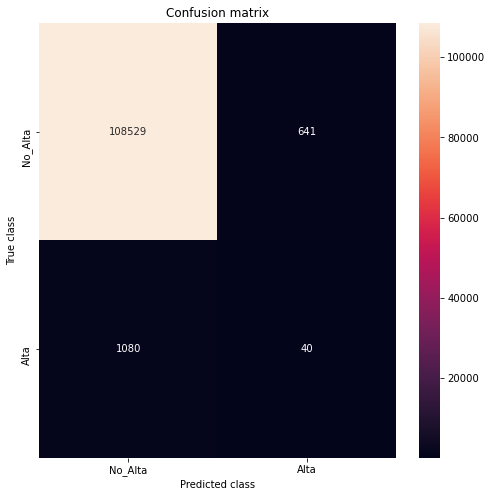

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    109170
           1       0.06      0.04      0.04      1120

    accuracy                           0.98    110290
   macro avg       0.52      0.51      0.52    110290
weighted avg       0.98      0.98      0.98    110290



In [59]:
pred_y = rf.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [60]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [61]:
feature_importances[feature_importances['important'] > 0.01]*100

,important
IPCASOS,11.199092
CANAL_REGISTRO,10.544279
FECHA_REGISTRO_MONTH,8.353704
FECHACONSUMO_MONTH,8.213063
1A_EMPCONSUL_PROV_DENS,6.357422
1A_EMPCONSUL_PROV_IDH,6.215612
FECHA_REGISTRO_WEEKDAY,5.622820
FECHACONSUMO_WEEKDAY,5.546653
BONDAD_EMAIL,3.353530
USU_DEPART_DEN_POB,2.014721


In [62]:
feature_importances[feature_importances['important'] > 0.01].shape

(20, 1)

------

------

##### **4.5.4 Combinamos OverSampling con Subsampling**

**Combinando SMOTE & RandomUnderSampler**

In [63]:
over = SMOTE(sampling_strategy = 0.3)
under = RandomUnderSampler(sampling_strategy = 0.5)
steps = [('over', over), ('under', under)]
pipeline = Pipeline(steps = steps)

In [64]:
X_train_res, y_train_res = pipeline.fit_resample(train_x, train_y)

In [65]:
print ("Distribution before resampling {}".format(Counter(train_y)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

Distribution before resampling Counter({0: 254753, 1: 2589})
Distribution after resampling Counter({0: 152850, 1: 76425})


In [66]:
rf = RandomForestClassifier(criterion = 'entropy', 
                            n_estimators = 20, 
                            max_features = 5, 
                            max_depth = None, 
                            n_jobs = -1,
                            random_state = 123)

rf.fit(X_train_res, y_train_res)

RandomForestClassifier(criterion='entropy', max_features=5, n_estimators=20,
                       n_jobs=-1, random_state=123)

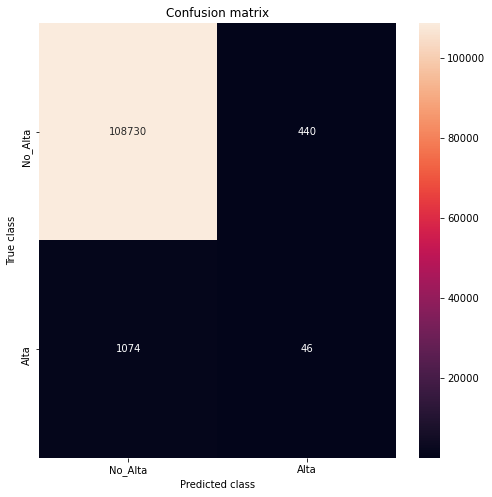

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    109170
           1       0.09      0.04      0.06      1120

    accuracy                           0.99    110290
   macro avg       0.54      0.52      0.53    110290
weighted avg       0.98      0.99      0.98    110290



In [67]:
pred_y = rf.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [68]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [69]:
feature_importances[feature_importances['important'] > 0.01] * 100

,important
CANAL_REGISTRO,6.188070
IPCASOS,5.207813
TIPO_TELF_MOVIL,5.124857
TIPO_TELF_EXTRANJERO,4.746940
1A_EMPCONSUL_SECTOR_TERCIARIO,4.287004
TIPO_TELF_NO_PUBLICO,3.819189
FECHACONSUMO_MONTH,3.646732
FECHA_REGISTRO_MONTH,3.566822
1A_EMPCONSUL_SECTOR_SECUNDARIO,3.450619
1A_DESCGRUPOPROD_PERF_PROMO,3.338419


In [70]:
feature_importances[feature_importances['important'] > 0.01].shape

(33, 1)

------

**Combinando SMOTE & NearMiss**

In [71]:
over = SMOTE(sampling_strategy = 'all')
under = NearMiss(sampling_strategy = 'majority', n_neighbors = 2, n_jobs = -1)
steps = [('over', over), ('under', under)]
pipeline = Pipeline(steps = steps)

In [72]:
X_train_res, y_train_res = pipeline.fit_resample(train_x, train_y)

In [73]:
print ("Distribution before resampling {}".format(Counter(train_y)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

Distribution before resampling Counter({0: 254753, 1: 2589})
Distribution after resampling Counter({0: 254753, 1: 254753})


In [74]:
rf = RandomForestClassifier(criterion = 'entropy', 
                            n_estimators = 20, 
                            max_features = 5, 
                            max_depth = None, 
                            n_jobs = -1,
                            random_state = 123)

rf.fit(X_train_res, y_train_res)

RandomForestClassifier(criterion='entropy', max_features=5, n_estimators=20,
                       n_jobs=-1, random_state=123)

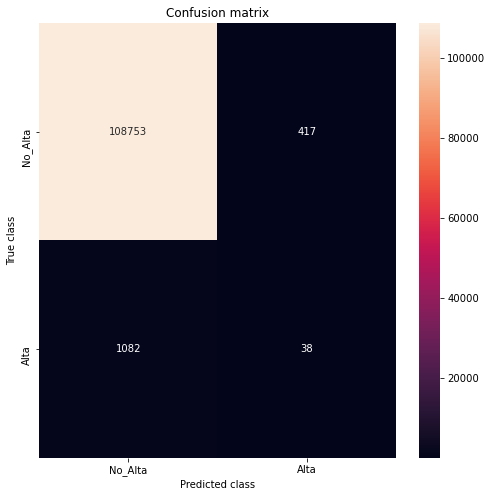

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    109170
           1       0.08      0.03      0.05      1120

    accuracy                           0.99    110290
   macro avg       0.54      0.52      0.52    110290
weighted avg       0.98      0.99      0.98    110290



In [75]:
pred_y = rf.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [76]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [77]:
feature_importances[feature_importances['important'] > 0.01] * 100

,important
CANAL_REGISTRO,6.247092
IPCASOS,5.188905
TIPO_TELF_MOVIL,4.857290
TIPO_TELF_NO_PUBLICO,4.549354
1A_EMPCONSUL_SECTOR_TERCIARIO,4.184278
TIPO_TELF_EXTRANJERO,3.970595
1A_EMPCONSUL_SECTOR_SECUNDARIO,3.670030
FECHACONSUMO_MONTH,3.555106
FECHA_REGISTRO_MONTH,3.458105
1A_DESCGRUPOPROD_PERF_PROMO,3.311275


In [78]:
feature_importances[feature_importances['important'] > 0.01].shape

(35, 1)

------

**SMOTETomek**

In [79]:
os_us = SMOTETomek(sampling_strategy = 'all')
X_train_res, y_train_res = os_us.fit_resample(train_x, train_y)

In [80]:
print ("Distribution before resampling {}".format(Counter(train_y)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

Distribution before resampling Counter({0: 254753, 1: 2589})
Distribution after resampling Counter({0: 254686, 1: 254686})


In [81]:
rf = RandomForestClassifier(criterion = 'entropy', 
                            n_estimators = 20, 
                            max_features = 5, 
                            max_depth = None, 
                            n_jobs = -1,
                            random_state = 123)

rf.fit(X_train_res, y_train_res)

RandomForestClassifier(criterion='entropy', max_features=5, n_estimators=20,
                       n_jobs=-1, random_state=123)

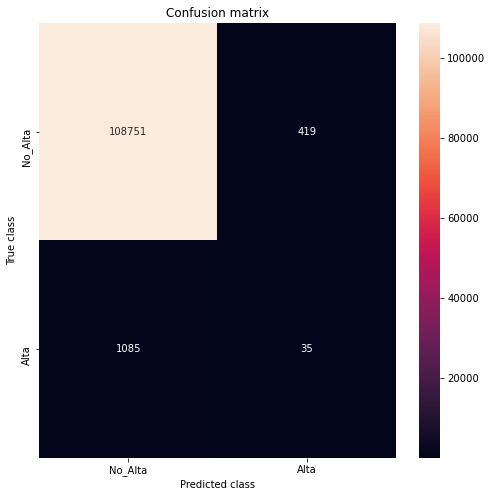

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    109170
           1       0.08      0.03      0.04      1120

    accuracy                           0.99    110290
   macro avg       0.53      0.51      0.52    110290
weighted avg       0.98      0.99      0.98    110290



In [82]:
pred_y = rf.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [83]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [84]:
feature_importances[feature_importances['important'] > 0.01] * 100

,important
CANAL_REGISTRO,6.330045
IPCASOS,5.259623
TIPO_TELF_MOVIL,4.664598
1A_EMPCONSUL_SECTOR_TERCIARIO,4.167744
TIPO_TELF_EXTRANJERO,4.044008
TIPO_TELF_NO_PUBLICO,3.899596
FECHACONSUMO_MONTH,3.544850
FECHA_REGISTRO_MONTH,3.443953
1A_EMPCONSUL_SECTOR_SECUNDARIO,3.403751
1A_DESCGRUPOPROD_PERF_PROMO,3.139984


In [85]:
feature_importances[feature_importances['important'] > 0.01].shape

(32, 1)

------

------

##### **4.5.5 Ensamble de Modelos con Balanceo**

Para esta estrategia usaremos un Clasificador de Ensamble que utiliza Bagging y el modelo será un RandomForest.

**Bagging**

In [86]:
bbc = BalancedBaggingClassifier(base_estimator = RandomForestClassifier(criterion = 'entropy', 
                                                                        n_estimators = 20, 
                                                                        max_features = 5, 
                                                                        max_depth = None, 
                                                                        n_jobs = -1,
                                                                        random_state = 123),
                                sampling_strategy = 'all',
                                n_estimators = 20,
                                replacement = False,
                                random_state = 123)

bbc.fit(train_x, train_y)

BalancedBaggingClassifier(base_estimator=RandomForestClassifier(criterion='entropy',
                                                                max_features=5,
                                                                n_estimators=20,
                                                                n_jobs=-1,
                                                                random_state=123),
                          n_estimators=20, random_state=123,
                          sampling_strategy='all')

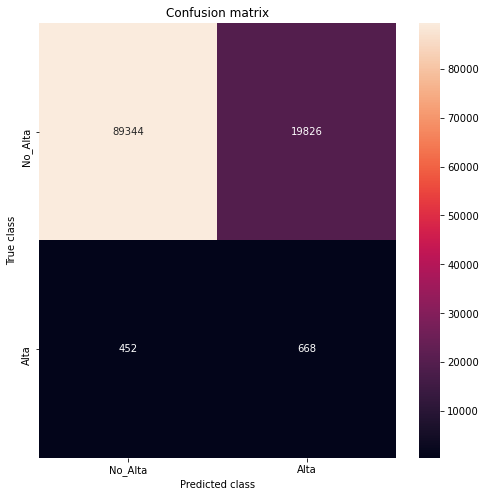

              precision    recall  f1-score   support

           0       0.99      0.82      0.90    109170
           1       0.03      0.60      0.06      1120

    accuracy                           0.82    110290
   macro avg       0.51      0.71      0.48    110290
weighted avg       0.99      0.82      0.89    110290



In [87]:
pred_y = bbc.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [88]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [89]:
feature_importances[feature_importances['important'] > 0.01]*100

,important
CANAL_REGISTRO,6.330045
IPCASOS,5.259623
TIPO_TELF_MOVIL,4.664598
1A_EMPCONSUL_SECTOR_TERCIARIO,4.167744
TIPO_TELF_EXTRANJERO,4.044008
TIPO_TELF_NO_PUBLICO,3.899596
FECHACONSUMO_MONTH,3.544850
FECHA_REGISTRO_MONTH,3.443953
1A_EMPCONSUL_SECTOR_SECUNDARIO,3.403751
1A_DESCGRUPOPROD_PERF_PROMO,3.139984


In [90]:
feature_importances[feature_importances['important'] > 0.01].shape

(32, 1)

------

**BalancedRandomForestClassifier**

In [91]:
brfc = BalancedRandomForestClassifier(criterion = 'entropy', 
                                    n_estimators = 20, 
                                    max_features = 5, 
                                    max_depth = None, 
                                    sampling_strategy = 'auto',
                                    n_jobs = -1,
                                    random_state = 123)

brfc.fit(train_x, train_y)

BalancedRandomForestClassifier(criterion='entropy', max_features=5,
                               n_estimators=20, n_jobs=-1, random_state=123)

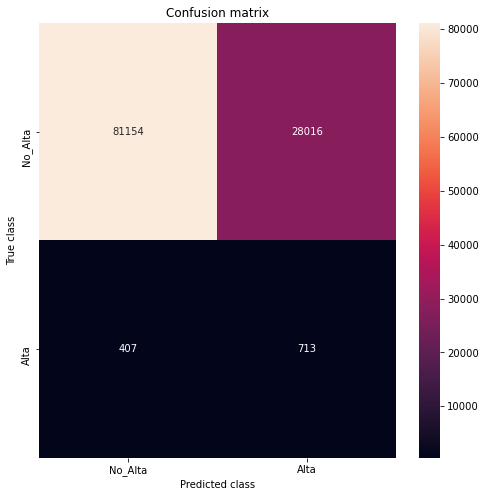

              precision    recall  f1-score   support

           0       1.00      0.74      0.85    109170
           1       0.02      0.64      0.05      1120

    accuracy                           0.74    110290
   macro avg       0.51      0.69      0.45    110290
weighted avg       0.99      0.74      0.84    110290



In [92]:
pred_y = brfc.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [93]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [94]:
feature_importances[feature_importances['important'] > 0.01]*100

,important
CANAL_REGISTRO,6.330045
IPCASOS,5.259623
TIPO_TELF_MOVIL,4.664598
1A_EMPCONSUL_SECTOR_TERCIARIO,4.167744
TIPO_TELF_EXTRANJERO,4.044008
TIPO_TELF_NO_PUBLICO,3.899596
FECHACONSUMO_MONTH,3.544850
FECHA_REGISTRO_MONTH,3.443953
1A_EMPCONSUL_SECTOR_SECUNDARIO,3.403751
1A_DESCGRUPOPROD_PERF_PROMO,3.139984


In [95]:
feature_importances[feature_importances['important'] > 0.01].shape

(32, 1)

------

**RUSBoostClassifier**

In [96]:
RUS = RUSBoostClassifier(base_estimator = RandomForestClassifier(criterion = 'entropy', 
                                                                        n_estimators = 20, 
                                                                        max_features = 5, 
                                                                        max_depth = None, 
                                                                        n_jobs = -1,
                                                                        random_state = 123),
                                sampling_strategy = 'majority',
                                n_estimators = 20,
                                replacement = False,
                                random_state = 123)

RUS.fit(train_x, train_y)

RUSBoostClassifier(base_estimator=RandomForestClassifier(criterion='entropy',
                                                         max_features=5,
                                                         n_estimators=20,
                                                         n_jobs=-1,
                                                         random_state=123),
                   n_estimators=20, random_state=123,
                   sampling_strategy='majority')

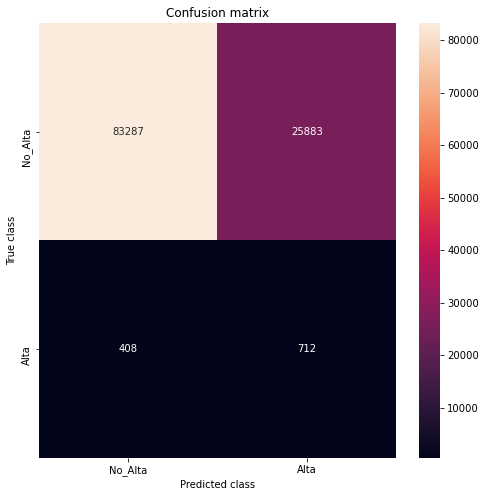

              precision    recall  f1-score   support

           0       1.00      0.76      0.86    109170
           1       0.03      0.64      0.05      1120

    accuracy                           0.76    110290
   macro avg       0.51      0.70      0.46    110290
weighted avg       0.99      0.76      0.86    110290



In [97]:
pred_y = RUS.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [98]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [99]:
feature_importances[feature_importances['important'] > 0.01]*100

,important
CANAL_REGISTRO,6.330045
IPCASOS,5.259623
TIPO_TELF_MOVIL,4.664598
1A_EMPCONSUL_SECTOR_TERCIARIO,4.167744
TIPO_TELF_EXTRANJERO,4.044008
TIPO_TELF_NO_PUBLICO,3.899596
FECHACONSUMO_MONTH,3.544850
FECHA_REGISTRO_MONTH,3.443953
1A_EMPCONSUL_SECTOR_SECUNDARIO,3.403751
1A_DESCGRUPOPROD_PERF_PROMO,3.139984


In [100]:
feature_importances[feature_importances['important'] > 0.01].shape

(32, 1)

---------------

**EasyEnsembleClassifier**

In [101]:
Easy = EasyEnsembleClassifier(sampling_strategy = 'majority',
                              n_estimators = 20,
                              replacement = False,
                              random_state = 123)

Easy.fit(train_x, train_y)

EasyEnsembleClassifier(n_estimators=20, random_state=123,
                       sampling_strategy='majority')

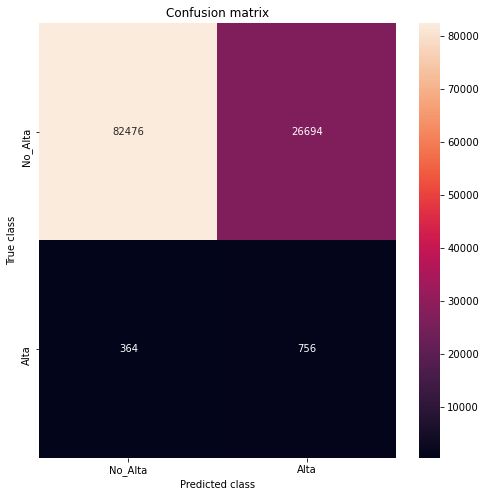

              precision    recall  f1-score   support

           0       1.00      0.76      0.86    109170
           1       0.03      0.68      0.05      1120

    accuracy                           0.75    110290
   macro avg       0.51      0.72      0.46    110290
weighted avg       0.99      0.75      0.85    110290



In [102]:
pred_y = Easy.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [103]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [104]:
feature_importances[feature_importances['important'] > 0.01]*100

,important
CANAL_REGISTRO,6.330045
IPCASOS,5.259623
TIPO_TELF_MOVIL,4.664598
1A_EMPCONSUL_SECTOR_TERCIARIO,4.167744
TIPO_TELF_EXTRANJERO,4.044008
TIPO_TELF_NO_PUBLICO,3.899596
FECHACONSUMO_MONTH,3.544850
FECHA_REGISTRO_MONTH,3.443953
1A_EMPCONSUL_SECTOR_SECUNDARIO,3.403751
1A_DESCGRUPOPROD_PERF_PROMO,3.139984


In [105]:
feature_importances[feature_importances['important'] > 0.01].shape

(32, 1)

---------------

---------------

---------------

# CONCLUSIONES

Realizaremos un modleo base sobre el que comparar los resultados. 

| Modelo | Accuracy  | NoAltas - Precision  | NoAltas - Recall  | Altas - Precision | Altas - Recall | # Variables utilizadas
|---|:---:|:---:|:---:|:---:|:---:|:---:|
| Baseline | 0.99 | 0.99 | 1.00 |  0.24 | 0.02 | 18 |

### **Resultados** 

| Modelo |Tecnica |Algoritmo   | Accuracy  |NoAltas - Precision  | NoAltas - Recall  | Altas - Precision | Altas - Recall | # Variables utilizadas
|---|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| Modelo 1 | **Penalización para compensar** | | 0.99 | 0.99 | 1.00 | 0.05 | 0.02| 21 |
| Modelo 2 | **Subsampling en la clase mayoritaria** | RandomUnderSampler | 0.74 | 0.99 | 0.74 | 0.02 | 0.63 | 23 |
| Modelo 3 | **Subsampling en la clase mayoritaria** | NearMiss| 0.16 | 0.99 | 0.15 | 0.01 | 0.91 | 26 |
| Modelo 4 | **Oversampling en la clase minoritaria** | SMOTE| 0.99 | 0.99 | 1.00 | 0.08 | 0.03 | 33 |
| Modelo 5 | **Oversampling en la clase minoritaria** | RandomOverSampler| 0.98 | 0.99 | 0.99 | 0.06 | 0.04 | 20 |
| Modelo 6 | **Combinamos OverSampling con Subsampling** | SMOTE & RandomUnderSampler | 0.99 | 0.99 | 1.00 | 0.09 | 0.04 | 33 |
| Modelo 7 | **Combinamos OverSampling con Subsampling** | SMOTE & NearMiss | 0.99 | 0.99 | 1.00 | 0.08 | 0.03 | 35 |
| Modelo 8 | **Combinamos OverSampling con Subsampling** | SMOTE-Tomek| 0.99 | 0.99 | 1.00 | 0.08 | 0.03 | 32 |
| Modelo 9 | **Ensamble de Modelos con Balanceo** | BalancedBaggingClassifier| 0.82 | 0.99 | 0.82 | 0.03 | 0.60 | 32 |
| Modelo 10 | **Ensamble de Modelos con Balanceo** | BalancedRandomForestClassifier| 0.74 | 1.00 | 0.74 | 0.02 | 0.64 | 32 |
| Modelo 11 | **Ensamble de Modelos con Balanceo** | RUSBoostClassifier| 0.76 | 1.00 | 0.76 | 0.03 | 0.64 | 32 |
| Modelo 12 | **Ensamble de Modelos con Balanceo** | EasyEnsembleClassifier| 0.75 | 1.00 | 0.76 | 0.03 | 0.68 | 32 |

Tras los resultados obtenidos y expuestos, podemos concluir que la técnica que mejores resultados nos ha proporcionado es **El Ensamble de modelos con balanceo**, en concreto el algoritmo seleccionado para nuestro modelo es **EasyEnsembleClassifier** que a pesar de ser un algoritmo con poco accuracy y que tiene una **precision de la clase de altas mala**, lo que nos centramos es en la métrica de recall, tanto en la clase minoritaria como mayoritaria, ya que como podemos comprobar, la técnica **NearMis** Tiene un muy buen recall de la clase clientes pero pésima de la clase no altas.

La técnica que más equilibrio presenta en la métrica de recall es la técnica **EasyEnsembleClassifier**. 